In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

### Create network of communications

In [51]:
path = 'Sender-receiver-weight.csv'
sendReceiverdf = pd.read_csv(path)

In [52]:
sendReceiverdf

Sender         Receiver  Weight
0     Richard Shapiro    Leslie Lawner       2
1     Richard Shapiro  Sandra McCubbin       2
2     Richard Shapiro    Jeff Dasovich      97
3     Richard Shapiro  Linda Robertson       7
4     Richard Shapiro     Paul Kaufman       7
...               ...              ...     ...
4503  Benjamin Rogers   Randall Martin       4
4504  Benjamin Rogers   Michelle Kelso       2
4505   Kerri Thompson       Kate Symes     684
4506   Kerri Thompson    Carla Hoffman      15
4507   Evelyn Metoyer       Kate Symes     788

[4508 rows x 3 columns]

In [4]:
import networkx as nx

G_comm = nx.DiGraph()


for idx, row in sendReceiverdf.iterrows():
    G_comm.add_edge(row['Sender'], row['Receiver'], weight=row['Weight'])

In [5]:
G_comm

### Create the network of similarity of communications

In [55]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [56]:
senderTextdf

Unnamed: 0              Sender  \
0            0      Kerri Thompson   
1            1       Chris Germany   
2            2      Evelyn Metoyer   
3            3        Gerald Nemec   
4            4          Tana Jones   
5            5     Mark E Haedicke   
6            6     James D Steffes   
7            7     John J Lavorato   
8            8   Richard B Sanders   
9            9     Richard Shapiro   
10          10    Shirley Crenshaw   
11          11       Jeff Dasovich   
12          12      Daren J Farmer   
13          13     Benjamin Rogers   
14          14    Vince J Kaminski   
15          15  Jeffrey A Shankman   
16          16         Susan Scott   
17          17          Sally Beck   
18          18            Kay Mann   
19          19      Carol St Clair   
20          20          Dan J Hyvl   
21          21         Mark Taylor   
22          22     Elizabeth Sager   
23          23     Sara Shackleton   
24          24          Kate Symes   
25          25      Mike McConnell   
26          26       Steven J Kean   
27          27    Maureen McVicker   

                                            All texts  
0   think price deal ; missing deal jeff richter s...  
1   nan; De Man change spelling Druckett Dracut ow...  
2   Hi Kate Mike Swerzbin ref Prebon counterparty ...  
3   Attached form; Attached form; Article relevant...  
4   connection execution new ISDA Master Agreement...  
5   efficiently EWS Mark  Forwarded Mark E Haedick...  
6   Jeff  helpful feedback prior starting deal fun...  
7   Original Message From Guerriero Michael mailto...  
8   kidding Columbus day found PUC Jeff DasovichEN...  
9   Leslieafter seeing point  writing  extremely r...  
10  Good morning Tom furnish following information...  
11  Jennifer Im Delainey got convened means delaye...  
12  Diane apologize getting late staffing addition...  
13  Vince power modeling presentation day wanted k...  
14  Sally Congratulations Vince; Sally Congratulat...  
15   From Christian LeBroc  ENRON   PM To Hugo Mor...  
16  going this Original Message From Dernehl Ginge...  
17  attended ASEs happy visit opinions ask Patti s...  
18  FYI Ill bring ONSI confidentiality agreement; ...  
19  Mark want include discussion online trading an...  
20  item attached GTC outside party provide Gas al...  
21  OK open AIG Energy Trading Inc financial gas  ...  
22  Mark Attached draft memo chance review thought...  
23  Tana think agreement listed Section all agreem...  
24  Pinnacle West working moving operations Arizon...  
25  Charlene Thanks email talked Sally times last ...  
26  think need clear indication Hogan Board going ...  
27  Attached presentation Public Affairs presented...

In [8]:
# text in sender
text_list = senderTextdf['All texts'].tolist()
sender_list = senderTextdf['Sender'].tolist()

In [9]:
# Calculate the similarity between the abstracts using n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(text_list)
similarity_matrix = cosine_similarity(X, X)

In [10]:
# Create a graph from the similarity matrix
# Draw an edge between papers with similarity in the fourth quartile

# Calculate the 75th percentile of the similarity matrix
import numpy as np
percentile_75 = np.percentile(similarity_matrix, 75)
print(f"75th percentile = {percentile_75}")

G_sim = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > percentile_75:
            G_sim.add_edge(sender_list[i], sender_list[j])

75th percentile = 0.44058040025146533


In [11]:
# Save the graph to a CSV file
nx.write_edgelist(G_sim, 'similarity_graph_emailDataset.csv', delimiter=',')

In [14]:
# Not sure what this list is for. We need to use the sender_list, because it contains the nodes in both graphs
# unique_elements = list(set(sendReceiverdf['Sender'].tolist() + sendReceiverdf['Receiver'].tolist()))
# node_list = list(unique_elements)
# len(node_list)

### Calculate the intersection for every node

In [12]:
# Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
intersection_dict = {}
for node in sender_list:
    # Check if node is in both graphs
    # TODO: Figure out why some nodes are not in both graphs
    if node not in G_comm.nodes or node not in G_sim.nodes:
        print(f"Node '{node}' is not in both graphs")
        continue
    network_comm_neighbors = set(G_comm.neighbors(node))
    network_sim_neighbors = set(G_sim.neighbors(node))
    intersection = network_comm_neighbors.intersection(network_sim_neighbors)
    union = network_comm_neighbors.union(network_sim_neighbors)
    jaccard_similarity = len(intersection) / len(union)
    intersection_dict[node] = {
        'intersection': intersection,
        'union': union,
        'jaccard_similarity': jaccard_similarity
    }

# # Save the intersection dictionary to a JSON file
# with open('./data/intersection_dict.json', 'w') as f:
#     json.dump(intersection_dict, f, indent=4)

Node 'Benjamin Rogers' is not in both graphs
Node 'Carol St Clair' is not in both graphs


In [13]:
intersection_dict

{'Kerri Thompson': {'intersection': {'Kate Symes'},
  'union': {'Carla Hoffman', 'Evelyn Metoyer', 'Kate Symes'},
  'jaccard_similarity': 0.3333333333333333},
 'Chris Germany': {'intersection': set(),
  'union': {'Airam Arteaga',
   'Alex Perkins',
   'Alfonso Trabulsi',
   'Alicia Perkins',
   'Alvin Thompson',
   'Amy Ochoa',
   'Andrea Ring',
   'Angel Fuller',
   'Angie Zeman',
   'Anne Bertino',
   'Audrey Cook',
   'Barbara N Gray',
   'Beverly Beaty',
   'Bhavna Pandya',
   'Brad McKay',
   'Brandon Oliveira',
   'Brenda H Fletcher',
   'Briant Baker',
   'Bryce Baxter',
   'Cecilia Olvera',
   'Chad Gronvold',
   'Chris Germany',
   'Chris Meyer',
   'Chris Ordway',
   'Christopher Spears',
   'Cindy Vachuska',
   'Clayton Vernon',
   'Colin Tonks',
   'Colleen Sullivan',
   'Cora Pendergrass',
   'Crystal Hyde',
   'Cynthia Franklin',
   'Dan J Hyvl',
   'Dan Junek',
   'Dana Daigle',
   'Daren J Farmer',
   'Darla Saucier',
   'Dave Scott',
   'David Oliver',
   'David Wile',

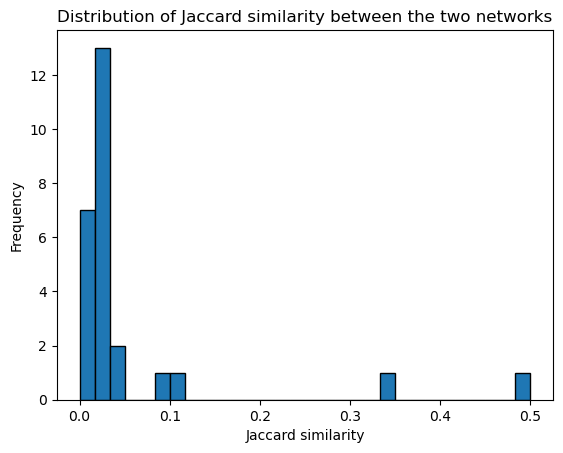

In [14]:
# Plot the distribution of the Jaccard similarity
jaccard_values = [value['jaccard_similarity'] for value in intersection_dict.values()]
fig, ax = plt.subplots()
ax.hist(jaccard_values, bins=30, edgecolor='black')
ax.set_xlabel('Jaccard similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Jaccard similarity between the two networks')
plt.show()

### Visualise networks

In [15]:
from matplotlib import patches
def visualise_sender_networks(selected_sender):

    # Get the neighbors of the selected sender in the two networks
    comm_neighbors = list(G_comm.neighbors(selected_sender))
    sim_neighbors = list(G_sim.neighbors(selected_sender))

    # Get the intersection
    intersection = set(comm_neighbors).intersection(set(sim_neighbors))
    only_comm = set(comm_neighbors).difference(set(sim_neighbors))
    only_sim = set(sim_neighbors).difference(set(comm_neighbors))

    G_vis = nx.Graph()
    for neighbor in only_comm:
        G_vis.add_edge(selected_sender, neighbor, network='communication')
    for neighbor in only_sim:
        G_vis.add_edge(selected_sender, neighbor, network='similarity')
    for neighbor in intersection:
        G_vis.add_edge(selected_sender, neighbor, network='both')

    # Visualise the graph
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G_vis)
    communication_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'communication']
    similarity_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'similarity']
    both_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'both']

    nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=communication_edges, ax=ax, edge_color='red')
    nx.draw_networkx_edges(G_vis, pos, edgelist=similarity_edges, ax=ax, edge_color='blue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')
    nx.draw_networkx_labels(G_vis, pos, ax=ax)

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')

    # Add a legend for edges only
    communication_patch = patches.Patch(color='red', label='Communication')
    similarity_patch = patches.Patch(color='blue', label='Similarity')
    both_patch = patches.Patch(color='green', label='Both')
    ax.legend(handles=[communication_patch, similarity_patch, both_patch])

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')
    
    plt.tight_layout()
    plt.show()

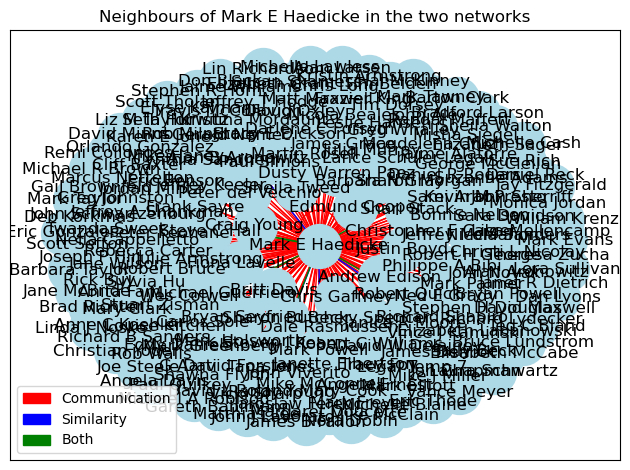

In [30]:
visualise_sender_networks('Mark E Haedicke')

In [20]:
 # Get the neighbors of the selected sender in the two networks
selected_sender ='Richard Shapiro'
comm_neighbors = list(G_comm.neighbors(selected_sender))
sim_neighbors = list(G_sim.neighbors(selected_sender))
intersection = set(comm_neighbors).intersection(set(sim_neighbors))
G_vis = nx.Graph()
for neighbor in intersection:
    G_vis.add_edge(selected_sender, neighbor, network='both')

In [27]:
# Step 2: Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G_vis)

# Step 3: Convert to 2D array (for easier iteration)
matrix_2d = adj_matrix.toarray()

# Step 4: Print "start point -> end point"
nodes = list(G_vis.nodes())
for i in range(len(matrix_2d)):
    for j in range(len(matrix_2d[i])):
        if matrix_2d[i][j] != 0:
            print(f'{nodes[i]} -> {nodes[j]}')


Richard Shapiro -> Jeff Dasovich
Richard Shapiro -> James D Steffes
Richard Shapiro -> Steven J Kean
Richard Shapiro -> Mark E Haedicke
Jeff Dasovich -> Richard Shapiro
James D Steffes -> Richard Shapiro
Steven J Kean -> Richard Shapiro
Mark E Haedicke -> Richard Shapiro


In [38]:
senderTextdf

Unnamed: 0              Sender  \
0            0      Kerri Thompson   
1            1       Chris Germany   
2            2      Evelyn Metoyer   
3            3        Gerald Nemec   
4            4          Tana Jones   
5            5     Mark E Haedicke   
6            6     James D Steffes   
7            7     John J Lavorato   
8            8   Richard B Sanders   
9            9     Richard Shapiro   
10          10    Shirley Crenshaw   
11          11       Jeff Dasovich   
12          12      Daren J Farmer   
13          13     Benjamin Rogers   
14          14    Vince J Kaminski   
15          15  Jeffrey A Shankman   
16          16         Susan Scott   
17          17          Sally Beck   
18          18            Kay Mann   
19          19      Carol St Clair   
20          20          Dan J Hyvl   
21          21         Mark Taylor   
22          22     Elizabeth Sager   
23          23     Sara Shackleton   
24          24          Kate Symes   
25          25      Mike McConnell   
26          26       Steven J Kean   
27          27    Maureen McVicker   

                                            All texts  
0   think price deal ; missing deal jeff richter s...  
1   nan; De Man change spelling Druckett Dracut ow...  
2   Hi Kate Mike Swerzbin ref Prebon counterparty ...  
3   Attached form; Attached form; Article relevant...  
4   connection execution new ISDA Master Agreement...  
5   efficiently EWS Mark  Forwarded Mark E Haedick...  
6   Jeff  helpful feedback prior starting deal fun...  
7   Original Message From Guerriero Michael mailto...  
8   kidding Columbus day found PUC Jeff DasovichEN...  
9   Leslieafter seeing point  writing  extremely r...  
10  Good morning Tom furnish following information...  
11  Jennifer Im Delainey got convened means delaye...  
12  Diane apologize getting late staffing addition...  
13  Vince power modeling presentation day wanted k...  
14  Sally Congratulations Vince; Sally Congratulat...  
15   From Christian LeBroc  ENRON   PM To Hugo Mor...  
16  going this Original Message From Dernehl Ginge...  
17  attended ASEs happy visit opinions ask Patti s...  
18  FYI Ill bring ONSI confidentiality agreement; ...  
19  Mark want include discussion online trading an...  
20  item attached GTC outside party provide Gas al...  
21  OK open AIG Energy Trading Inc financial gas  ...  
22  Mark Attached draft memo chance review thought...  
23  Tana think agreement listed Section all agreem...  
24  Pinnacle West working moving operations Arizon...  
25  Charlene Thanks email talked Sally times last ...  
26  think need clear indication Hogan Board going ...  
27  Attached presentation Public Affairs presented...

In [40]:
# List to store tuples of nodes with non-empty intersections
intersections = []

# Iterate through the dictionary
for node, data in intersection_dict.items():
    # Check if the intersection is non-empty
    if data['intersection']:
        # For each item in the intersection, create a tuple with the current node
        for intersect_node in data['intersection']:
            intersections.append((node, intersect_node))

print(intersections)


[('Kerri Thompson', 'Kate Symes'), ('Evelyn Metoyer', 'Kate Symes'), ('Gerald Nemec', 'Susan Scott'), ('Gerald Nemec', 'Richard B Sanders'), ('Gerald Nemec', 'Mark Taylor'), ('Gerald Nemec', 'Dan J Hyvl'), ('Gerald Nemec', 'Tana Jones'), ('Tana Jones', 'Elizabeth Sager'), ('Tana Jones', 'Steven J Kean'), ('Tana Jones', 'Richard B Sanders'), ('Tana Jones', 'Mark Taylor'), ('Tana Jones', 'Mark E Haedicke'), ('Tana Jones', 'Dan J Hyvl'), ('Tana Jones', 'Sara Shackleton'), ('Mark E Haedicke', 'Elizabeth Sager'), ('Mark E Haedicke', 'Steven J Kean'), ('Mark E Haedicke', 'Richard B Sanders'), ('Mark E Haedicke', 'Mark Taylor'), ('Mark E Haedicke', 'Richard Shapiro'), ('Mark E Haedicke', 'Jeffrey A Shankman'), ('James D Steffes', 'Jeff Dasovich'), ('James D Steffes', 'Richard B Sanders'), ('James D Steffes', 'Steven J Kean'), ('James D Steffes', 'Richard Shapiro'), ('Richard B Sanders', 'Elizabeth Sager'), ('Richard B Sanders', 'James D Steffes'), ('Richard B Sanders', 'Steven J Kean'), ('Ric

In [41]:
def find_unique_names(tuples):
 """Extracts unique names from a list of tuples and returns them as a list."""

 unique_names = set()
 for tuple in tuples:
   unique_names.update(tuple)  # Efficiently adds unique names from each tuple

 return list(unique_names)  # Converts the set to a list

# Example usage:
name_tuples = [('Kerri Thompson', 'Kate Symes'), ('Evelyn Metoyer', 'Kate Symes'), ('Gerald Nemec', 'Susan Scott')]
unique_names = find_unique_names(intersections)
print(unique_names)  # Output: ['Susan Scott', 'Evelyn Metoyer', 'Gerald Nemec', 'Kerri Thompson', 'Kate Symes']

['James D Steffes', 'Sally Beck', 'Shirley Crenshaw', 'Gerald Nemec', 'Maureen McVicker', 'Mark E Haedicke', 'Kate Symes', 'Tana Jones', 'Richard B Sanders', 'Daren J Farmer', 'Mark Taylor', 'Vince J Kaminski', 'Mike McConnell', 'Kay Mann', 'John J Lavorato', 'Jeffrey A Shankman', 'Sara Shackleton', 'Elizabeth Sager', 'Steven J Kean', 'Kerri Thompson', 'Susan Scott', 'Richard Shapiro', 'Evelyn Metoyer', 'Jeff Dasovich', 'Dan J Hyvl']


In [42]:
len(unique_names)

25

In [43]:
senderTextdf

Unnamed: 0              Sender  \
0            0      Kerri Thompson   
1            1       Chris Germany   
2            2      Evelyn Metoyer   
3            3        Gerald Nemec   
4            4          Tana Jones   
5            5     Mark E Haedicke   
6            6     James D Steffes   
7            7     John J Lavorato   
8            8   Richard B Sanders   
9            9     Richard Shapiro   
10          10    Shirley Crenshaw   
11          11       Jeff Dasovich   
12          12      Daren J Farmer   
13          13     Benjamin Rogers   
14          14    Vince J Kaminski   
15          15  Jeffrey A Shankman   
16          16         Susan Scott   
17          17          Sally Beck   
18          18            Kay Mann   
19          19      Carol St Clair   
20          20          Dan J Hyvl   
21          21         Mark Taylor   
22          22     Elizabeth Sager   
23          23     Sara Shackleton   
24          24          Kate Symes   
25          25      Mike McConnell   
26          26       Steven J Kean   
27          27    Maureen McVicker   

                                            All texts  
0   think price deal ; missing deal jeff richter s...  
1   nan; De Man change spelling Druckett Dracut ow...  
2   Hi Kate Mike Swerzbin ref Prebon counterparty ...  
3   Attached form; Attached form; Article relevant...  
4   connection execution new ISDA Master Agreement...  
5   efficiently EWS Mark  Forwarded Mark E Haedick...  
6   Jeff  helpful feedback prior starting deal fun...  
7   Original Message From Guerriero Michael mailto...  
8   kidding Columbus day found PUC Jeff DasovichEN...  
9   Leslieafter seeing point  writing  extremely r...  
10  Good morning Tom furnish following information...  
11  Jennifer Im Delainey got convened means delaye...  
12  Diane apologize getting late staffing addition...  
13  Vince power modeling presentation day wanted k...  
14  Sally Congratulations Vince; Sally Congratulat...  
15   From Christian LeBroc  ENRON   PM To Hugo Mor...  
16  going this Original Message From Dernehl Ginge...  
17  attended ASEs happy visit opinions ask Patti s...  
18  FYI Ill bring ONSI confidentiality agreement; ...  
19  Mark want include discussion online trading an...  
20  item attached GTC outside party provide Gas al...  
21  OK open AIG Energy Trading Inc financial gas  ...  
22  Mark Attached draft memo chance review thought...  
23  Tana think agreement listed Section all agreem...  
24  Pinnacle West working moving operations Arizon...  
25  Charlene Thanks email talked Sally times last ...  
26  think need clear indication Hogan Board going ...  
27  Attached presentation Public Affairs presented...

In [45]:
import pandas as pd
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Function to tokenize text, remove punctuation, stopwords, and find top 5 lemmas of frequency
def get_top_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemma_counts = Counter(lemmas)
    top_lemmas = lemma_counts.most_common(5)
    return top_lemmas

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    
    # Iterate through matched rows
    for index, row in matched_rows.iterrows():
        text = row['All texts']
        top_lemmas = get_top_lemmas(text)
        print(f"Sender Name: {name}")
        print("Top 5 Lemmas of Frequency:")
        for lemma, freq in top_lemmas:
            print(f"{lemma}: {freq}")
        print()


Sender Name: James D Steffes
Top 5 Lemmas of Frequency:
risk: 500
jeff: 407
jim: 394
market: 383
james: 365

Sender Name: Sally Beck
Top 5 Lemmas of Frequency:
sally: 3251
week: 1643
thanks: 1576
know: 1563
enron: 1449

Sender Name: Shirley Crenshaw
Top 5 Lemmas of Frequency:
shirley: 400
vince: 311
thanks: 250
know: 197
research: 185

Sender Name: Gerald Nemec
Top 5 Lemmas of Frequency:
gerald: 1384
agreement: 1164
subject: 959
attached: 953
cc: 879

Sender Name: Maureen McVicker
Top 5 Lemmas of Frequency:
steve: 373
pm: 233
maureen: 224
subject: 220
meeting: 211

Sender Name: Mark E Haedicke
Top 5 Lemmas of Frequency:
mark: 3363
e: 1316
subject: 1163
cc: 1047
pm: 1037

Sender Name: Kate Symes
Top 5 Lemmas of Frequency:
deal: 11371
kate: 9518
subject: 4982
cc: 4934
thanks: 4853

Sender Name: Tana Jones
Top 5 Lemmas of Frequency:
tana: 6566
subject: 4693
cc: 4464
pm: 3532
joneshouectect: 2965

Sender Name: Richard B Sanders
Top 5 Lemmas of Frequency:
richard: 3016
b: 2457
subject: 2159

In [62]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [63]:
senderTextdf

Unnamed: 0              Sender  \
0            0      Kerri Thompson   
1            1       Chris Germany   
2            2      Evelyn Metoyer   
3            3        Gerald Nemec   
4            4          Tana Jones   
5            5     Mark E Haedicke   
6            6     James D Steffes   
7            7     John J Lavorato   
8            8   Richard B Sanders   
9            9     Richard Shapiro   
10          10    Shirley Crenshaw   
11          11       Jeff Dasovich   
12          12      Daren J Farmer   
13          13     Benjamin Rogers   
14          14    Vince J Kaminski   
15          15  Jeffrey A Shankman   
16          16         Susan Scott   
17          17          Sally Beck   
18          18            Kay Mann   
19          19      Carol St Clair   
20          20          Dan J Hyvl   
21          21         Mark Taylor   
22          22     Elizabeth Sager   
23          23     Sara Shackleton   
24          24          Kate Symes   
25          25      Mike McConnell   
26          26       Steven J Kean   
27          27    Maureen McVicker   

                                            All texts  
0   think price deal ; missing deal jeff richter s...  
1   nan; De Man change spelling Druckett Dracut ow...  
2   Hi Kate Mike Swerzbin ref Prebon counterparty ...  
3   Attached form; Attached form; Article relevant...  
4   connection execution new ISDA Master Agreement...  
5   efficiently EWS Mark  Forwarded Mark E Haedick...  
6   Jeff  helpful feedback prior starting deal fun...  
7   Original Message From Guerriero Michael mailto...  
8   kidding Columbus day found PUC Jeff DasovichEN...  
9   Leslieafter seeing point  writing  extremely r...  
10  Good morning Tom furnish following information...  
11  Jennifer Im Delainey got convened means delaye...  
12  Diane apologize getting late staffing addition...  
13  Vince power modeling presentation day wanted k...  
14  Sally Congratulations Vince; Sally Congratulat...  
15   From Christian LeBroc  ENRON   PM To Hugo Mor...  
16  going this Original Message From Dernehl Ginge...  
17  attended ASEs happy visit opinions ask Patti s...  
18  FYI Ill bring ONSI confidentiality agreement; ...  
19  Mark want include discussion online trading an...  
20  item attached GTC outside party provide Gas al...  
21  OK open AIG Energy Trading Inc financial gas  ...  
22  Mark Attached draft memo chance review thought...  
23  Tana think agreement listed Section all agreem...  
24  Pinnacle West working moving operations Arizon...  
25  Charlene Thanks email talked Sally times last ...  
26  think need clear indication Hogan Board going ...  
27  Attached presentation Public Affairs presented...

In [59]:
senderTextdf['Sender']

0         Kerri Thompson
1          Chris Germany
2         Evelyn Metoyer
3           Gerald Nemec
4             Tana Jones
5        Mark E Haedicke
6        James D Steffes
7        John J Lavorato
8      Richard B Sanders
9        Richard Shapiro
10      Shirley Crenshaw
11         Jeff Dasovich
12        Daren J Farmer
13       Benjamin Rogers
14      Vince J Kaminski
15    Jeffrey A Shankman
16           Susan Scott
17            Sally Beck
18              Kay Mann
19        Carol St Clair
20            Dan J Hyvl
21           Mark Taylor
22       Elizabeth Sager
23       Sara Shackleton
24            Kate Symes
25        Mike McConnell
26         Steven J Kean
27      Maureen McVicker
Name: Sender, dtype: object

In [64]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



# Function to tokenize text, remove punctuation, and stopwords, and find lemmas
def get_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return set(lemmas)

# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    
    # Find common lemmas across rows for the sender
    common_lemmas = set.intersection(*lemma_sets)
    
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas

# Find common lemmas across all rows for each sender
common_lemmas_all = set.intersection(*lemmas_by_sender.values())

# Print common lemmas for each sender
for sender, common_lemmas in lemmas_by_sender.items():
    print(f"Sender Name: {sender}")
    print("Common Lemmas:")
    print(common_lemmas)
    print()

# Print common lemmas across all rows for all senders
print("Common Lemmas across all Senders:")
print(common_lemmas_all)


Sender Name: James D Steffes
Common Lemmas:
{'profited', 'weimplement', 'tracy', 'damn', 'delaineywhaley', 'martin', 'carrying', 'petition', 'robin', 'gsheereiccnetcom', 'merging', 'foward', 'e', 'trouble', 'edit', 'kwh', 'dean', 'wait', 'fultoncorpenronenron', 'lot', 'hainhouectect', 'trueup', 'uniform', 'ai', 'regionsrtos', 'calculate', 'jluckhardtdbsrcom', 'offer', 'reynanaenronenron', 'describes', 'drawback', 'phillip', 'harrisetsenronenron', 'trajectory', 'assembly', 'blame', 'stakeholder', 'committments', 'formalize', 'involved', 'businesscom', 'request', 'bizarre', 'federal', 'ame', 'read', 'produced', 'thought', 'press', 'andy', 'escalante', 'witholding', 'surv', 'bob', 'jornlforasenergycom', 'florida', 'realize', 'educate', 'term', 'session', 'baja', 'paula', 'karen', 'assist', 'wscobeecaithnessenergycom', 'williamsenrondevelopmentenrondevelopment', 'emergency', 'underscheduling', 'ruled', 'get', 'samuel', 'calgerect', 'voluntarily', 'chan', 'midyear', 'lay', 'anticipates', 'c

In [76]:
lemmas_by_sender

{'James D Steffes': {'profited',
  'weimplement',
  'tracy',
  'damn',
  'delaineywhaley',
  'martin',
  'carrying',
  'petition',
  'robin',
  'gsheereiccnetcom',
  'merging',
  'foward',
  'e',
  'trouble',
  'edit',
  'kwh',
  'dean',
  'wait',
  'fultoncorpenronenron',
  'lot',
  'hainhouectect',
  'trueup',
  'uniform',
  'ai',
  'regionsrtos',
  'calculate',
  'jluckhardtdbsrcom',
  'offer',
  'reynanaenronenron',
  'describes',
  'drawback',
  'phillip',
  'harrisetsenronenron',
  'trajectory',
  'assembly',
  'blame',
  'stakeholder',
  'committments',
  'formalize',
  'involved',
  'businesscom',
  'request',
  'bizarre',
  'federal',
  'ame',
  'read',
  'produced',
  'thought',
  'press',
  'andy',
  'escalante',
  'witholding',
  'surv',
  'bob',
  'jornlforasenergycom',
  'florida',
  'realize',
  'educate',
  'term',
  'session',
  'baja',
  'paula',
  'karen',
  'assist',
  'wscobeecaithnessenergycom',
  'williamsenrondevelopmentenrondevelopment',
  'emergency',
  'under

In [65]:
common_lemmas_all

{'add',
 'afternoon',
 'also',
 'april',
 'ask',
 'asked',
 'b',
 'buy',
 'c',
 'called',
 'cc',
 'change',
 'check',
 'chris',
 'conference',
 'contact',
 'date',
 'day',
 'detail',
 'email',
 'end',
 'energy',
 'find',
 'fixed',
 'following',
 'friday',
 'go',
 'going',
 'good',
 'got',
 'great',
 'heard',
 'help',
 'hour',
 'ill',
 'im',
 'info',
 'interest',
 'ive',
 'jeff',
 'june',
 'k',
 'know',
 'left',
 'let',
 'like',
 'look',
 'mark',
 'message',
 'mike',
 'mind',
 'minute',
 'month',
 'morning',
 'need',
 'number',
 'office',
 'ok',
 'one',
 'pas',
 'phone',
 'pm',
 'point',
 'possible',
 'power',
 'price',
 'problem',
 'received',
 'request',
 'right',
 'risk',
 'said',
 'say',
 'schedule',
 'send',
 'sent',
 'service',
 'soon',
 'sorry',
 'status',
 'subject',
 'sure',
 'system',
 'talk',
 'talking',
 'term',
 'th',
 'thank',
 'thanks',
 'thing',
 'think',
 'thought',
 'time',
 'today',
 'told',
 'trying',
 'want',
 'wanted',
 'way',
 'week',
 'work',
 'yes',
 'yesterday'

In [77]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Function to tokenize text, remove punctuation, and stopwords, and find top 5 lemmas
def get_top_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemma_counts = pd.Series(lemmas).value_counts().head(5)
    return set(lemma_counts.index)

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect top 5 lemmas
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_top_lemmas(text))
    
    # Find top 5 common lemmas across rows for the sender
    common_lemmas = set.intersection(*lemma_sets)
    
    # Print top 5 common lemmas for the sender
    print(f"Sender Name: {name}")
    print("Top 5 Common Lemmas:")
    print(common_lemmas)
    print()


Sender Name: James D Steffes
Top 5 Common Lemmas:
{'risk', 'jeff', 'jim', 'james', 'market'}

Sender Name: Sally Beck
Top 5 Common Lemmas:
{'sally', 'week', 'enron', 'thanks', 'know'}

Sender Name: Shirley Crenshaw
Top 5 Common Lemmas:
{'shirley', 'vince', 'thanks', 'know', 'research'}

Sender Name: Gerald Nemec
Top 5 Common Lemmas:
{'subject', 'agreement', 'gerald', 'cc', 'attached'}

Sender Name: Maureen McVicker
Top 5 Common Lemmas:
{'subject', 'pm', 'meeting', 'steve', 'maureen'}

Sender Name: Mark E Haedicke
Top 5 Common Lemmas:
{'subject', 'mark', 'pm', 'e', 'cc'}

Sender Name: Kate Symes
Top 5 Common Lemmas:
{'subject', 'thanks', 'cc', 'kate', 'deal'}

Sender Name: Tana Jones
Top 5 Common Lemmas:
{'tana', 'subject', 'pm', 'cc', 'joneshouectect'}

Sender Name: Richard B Sanders
Top 5 Common Lemmas:
{'subject', 'pm', 'cc', 'b', 'richard'}

Sender Name: Daren J Farmer
Top 5 Common Lemmas:
{'subject', 'cc', 'j', 'daren', 'deal'}

Sender Name: Mark Taylor
Top 5 Common Lemmas:
{'subje

In [ ]:
sender_lemmas = {
    'James D Steffes': {'risk', 'jeff', 'jim', 'james', 'market'},
    'Sally Beck': {'sally', 'week', 'enron', 'thanks', 'know'},
    'Shirley Crenshaw': {'shirley', 'vince', 'thanks', 'know', 'research'},
    'Gerald Nemec': {'subject', 'agreement', 'gerald', 'cc', 'attached'},
    'Maureen McVicker': {'subject', 'pm', 'meeting', 'steve', 'maureen'}
    # Add other sender names and their top 5 common lemmas here
}

# Analyze the lemmas for each sender from most to least common
for sender, lemmas in sender_lemmas.items():
    # Count the frequency of each lemma
    lemma_frequency = {}
    for lemma in lemmas:
        count = sum(lemma in lemmas for lemmas in sender_lemmas.values())
        lemma_frequency[lemma] = count
    
    # Sort lemmas by frequency from most to least common
    sorted_lemmas = sorted(lemma_frequency.items(), key=lambda x: x[1], reverse=True)
    
    # Print the results
    print(f"Sender: {sender}")
    print("Most to least common lemmas:")
    for lemma, frequency in sorted_lemmas:
        print(f"{lemma}: {frequency}")
    print()


In [70]:
# Function to tokenize text, remove punctuation, and stopwords, and find top 5 lemmas
def get_top_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemma_counts = pd.Series(lemmas).value_counts().head(5)
    return set(lemma_counts.index)

In [71]:
# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    
    # Find common lemmas across rows for the sender
    common_lemmas = set.intersection(*lemma_sets)
    
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas

# Find common lemmas across all rows for each sender
common_lemmas_all = set.intersection(*lemmas_by_sender.values())


In [ ]:
# Find common lemmas across all rows for each sender
common_lemmas_all = set.intersection(*lemmas_by_sender.values())


In [78]:
lemmas_by_sender

{'James D Steffes': {'profited',
  'weimplement',
  'tracy',
  'damn',
  'delaineywhaley',
  'martin',
  'carrying',
  'petition',
  'robin',
  'gsheereiccnetcom',
  'merging',
  'foward',
  'e',
  'trouble',
  'edit',
  'kwh',
  'dean',
  'wait',
  'fultoncorpenronenron',
  'lot',
  'hainhouectect',
  'trueup',
  'uniform',
  'ai',
  'regionsrtos',
  'calculate',
  'jluckhardtdbsrcom',
  'offer',
  'reynanaenronenron',
  'describes',
  'drawback',
  'phillip',
  'harrisetsenronenron',
  'trajectory',
  'assembly',
  'blame',
  'stakeholder',
  'committments',
  'formalize',
  'involved',
  'businesscom',
  'request',
  'bizarre',
  'federal',
  'ame',
  'read',
  'produced',
  'thought',
  'press',
  'andy',
  'escalante',
  'witholding',
  'surv',
  'bob',
  'jornlforasenergycom',
  'florida',
  'realize',
  'educate',
  'term',
  'session',
  'baja',
  'paula',
  'karen',
  'assist',
  'wscobeecaithnessenergycom',
  'williamsenrondevelopmentenrondevelopment',
  'emergency',
  'under

In [81]:
sender_lemmas = lemmas_by_sender

# Collect all lemmas from all senders
all_lemmas = set()
for lemmas in sender_lemmas.values():
    all_lemmas.update(lemmas)

# Count the frequency of each lemma across all senders
lemma_frequency = {}
for lemma in all_lemmas:
    count = sum(lemma in lemmas for lemmas in sender_lemmas.values())
    lemma_frequency[lemma] = count

# Sort lemmas by frequency from most to least common
sorted_lemmas = sorted(lemma_frequency.items(), key=lambda x: x[1], reverse=True)

# Print the results
print("Most to least common lemmas for all senders in the intersection node:")
for lemma, frequency in sorted_lemmas:
    print(f"{lemma}: {frequency}")


Most to least common lemmas for all senders in the intersection node:
power: 25
left: 25
ill: 25
heard: 25
contact: 25
help: 25
say: 25
june: 25
wanted: 25
pas: 25
told: 25
ok: 25
trying: 25
said: 25
yes: 25
look: 25
yesterday: 25
cc: 25
buy: 25
message: 25
one: 25
thank: 25
hour: 25
term: 25
think: 25
mark: 25
end: 25
status: 25
go: 25
minute: 25
b: 25
im: 25
work: 25
price: 25
schedule: 25
week: 25
possible: 25
mike: 25
mind: 25
morning: 25
month: 25
time: 25
called: 25
following: 25
change: 25
interest: 25
send: 25
add: 25
email: 25
find: 25
request: 25
day: 25
problem: 25
received: 25
sure: 25
good: 25
like: 25
thought: 25
chris: 25
thanks: 25
know: 25
friday: 25
afternoon: 25
phone: 25
energy: 25
check: 25
point: 25
let: 25
k: 25
way: 25
system: 25
office: 25
service: 25
c: 25
jeff: 25
need: 25
ask: 25
great: 25
soon: 25
conference: 25
detail: 25
sent: 25
date: 25
want: 25
today: 25
th: 25
subject: 25
fixed: 25
talk: 25
talking: 25
pm: 25
info: 25
number: 25
also: 25
got: 25
sorry

In [82]:
sorted_lemmas

[('power', 25),
 ('left', 25),
 ('ill', 25),
 ('heard', 25),
 ('contact', 25),
 ('help', 25),
 ('say', 25),
 ('june', 25),
 ('wanted', 25),
 ('pas', 25),
 ('told', 25),
 ('ok', 25),
 ('trying', 25),
 ('said', 25),
 ('yes', 25),
 ('look', 25),
 ('yesterday', 25),
 ('cc', 25),
 ('buy', 25),
 ('message', 25),
 ('one', 25),
 ('thank', 25),
 ('hour', 25),
 ('term', 25),
 ('think', 25),
 ('mark', 25),
 ('end', 25),
 ('status', 25),
 ('go', 25),
 ('minute', 25),
 ('b', 25),
 ('im', 25),
 ('work', 25),
 ('price', 25),
 ('schedule', 25),
 ('week', 25),
 ('possible', 25),
 ('mike', 25),
 ('mind', 25),
 ('morning', 25),
 ('month', 25),
 ('time', 25),
 ('called', 25),
 ('following', 25),
 ('change', 25),
 ('interest', 25),
 ('send', 25),
 ('add', 25),
 ('email', 25),
 ('find', 25),
 ('request', 25),
 ('day', 25),
 ('problem', 25),
 ('received', 25),
 ('sure', 25),
 ('good', 25),
 ('like', 25),
 ('thought', 25),
 ('chris', 25),
 ('thanks', 25),
 ('know', 25),
 ('friday', 25),
 ('afternoon', 25),
 (

In [84]:
# Function to lemmatize a word
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Lemmatize the first element of each tuple
lemmatized_word_freq = [(lemmatize_word(word), freq) for word, freq in sorted_lemmas]

# Print the lemmatized list
print(lemmatized_word_freq)

[('power', 25), ('left', 25), ('ill', 25), ('heard', 25), ('contact', 25), ('help', 25), ('say', 25), ('june', 25), ('wanted', 25), ('pa', 25), ('told', 25), ('ok', 25), ('trying', 25), ('said', 25), ('yes', 25), ('look', 25), ('yesterday', 25), ('cc', 25), ('buy', 25), ('message', 25), ('one', 25), ('thank', 25), ('hour', 25), ('term', 25), ('think', 25), ('mark', 25), ('end', 25), ('status', 25), ('go', 25), ('minute', 25), ('b', 25), ('im', 25), ('work', 25), ('price', 25), ('schedule', 25), ('week', 25), ('possible', 25), ('mike', 25), ('mind', 25), ('morning', 25), ('month', 25), ('time', 25), ('called', 25), ('following', 25), ('change', 25), ('interest', 25), ('send', 25), ('add', 25), ('email', 25), ('find', 25), ('request', 25), ('day', 25), ('problem', 25), ('received', 25), ('sure', 25), ('good', 25), ('like', 25), ('thought', 25), ('chris', 25), ('thanks', 25), ('know', 25), ('friday', 25), ('afternoon', 25), ('phone', 25), ('energy', 25), ('check', 25), ('point', 25), ('le

In [85]:
lemmatized_word_freq

[('power', 25),
 ('left', 25),
 ('ill', 25),
 ('heard', 25),
 ('contact', 25),
 ('help', 25),
 ('say', 25),
 ('june', 25),
 ('wanted', 25),
 ('pa', 25),
 ('told', 25),
 ('ok', 25),
 ('trying', 25),
 ('said', 25),
 ('yes', 25),
 ('look', 25),
 ('yesterday', 25),
 ('cc', 25),
 ('buy', 25),
 ('message', 25),
 ('one', 25),
 ('thank', 25),
 ('hour', 25),
 ('term', 25),
 ('think', 25),
 ('mark', 25),
 ('end', 25),
 ('status', 25),
 ('go', 25),
 ('minute', 25),
 ('b', 25),
 ('im', 25),
 ('work', 25),
 ('price', 25),
 ('schedule', 25),
 ('week', 25),
 ('possible', 25),
 ('mike', 25),
 ('mind', 25),
 ('morning', 25),
 ('month', 25),
 ('time', 25),
 ('called', 25),
 ('following', 25),
 ('change', 25),
 ('interest', 25),
 ('send', 25),
 ('add', 25),
 ('email', 25),
 ('find', 25),
 ('request', 25),
 ('day', 25),
 ('problem', 25),
 ('received', 25),
 ('sure', 25),
 ('good', 25),
 ('like', 25),
 ('thought', 25),
 ('chris', 25),
 ('thanks', 25),
 ('know', 25),
 ('friday', 25),
 ('afternoon', 25),
 ('

In [86]:
# Function to lemmatize a word
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Lemmatize the first element of each tuple
lemmatized_word_freq = [(lemmatize_word(word), freq) for word, freq in sorted_lemmas]

# Print the lemmatized list
print(lemmatized_word_freq)

[('power', 25), ('left', 25), ('ill', 25), ('heard', 25), ('contact', 25), ('help', 25), ('say', 25), ('june', 25), ('wanted', 25), ('pa', 25), ('told', 25), ('ok', 25), ('trying', 25), ('said', 25), ('yes', 25), ('look', 25), ('yesterday', 25), ('cc', 25), ('buy', 25), ('message', 25), ('one', 25), ('thank', 25), ('hour', 25), ('term', 25), ('think', 25), ('mark', 25), ('end', 25), ('status', 25), ('go', 25), ('minute', 25), ('b', 25), ('im', 25), ('work', 25), ('price', 25), ('schedule', 25), ('week', 25), ('possible', 25), ('mike', 25), ('mind', 25), ('morning', 25), ('month', 25), ('time', 25), ('called', 25), ('following', 25), ('change', 25), ('interest', 25), ('send', 25), ('add', 25), ('email', 25), ('find', 25), ('request', 25), ('day', 25), ('problem', 25), ('received', 25), ('sure', 25), ('good', 25), ('like', 25), ('thought', 25), ('chris', 25), ('thanks', 25), ('know', 25), ('friday', 25), ('afternoon', 25), ('phone', 25), ('energy', 25), ('check', 25), ('point', 25), ('le

In [87]:
lemmatized_word_freq

[('power', 25),
 ('left', 25),
 ('ill', 25),
 ('heard', 25),
 ('contact', 25),
 ('help', 25),
 ('say', 25),
 ('june', 25),
 ('wanted', 25),
 ('pa', 25),
 ('told', 25),
 ('ok', 25),
 ('trying', 25),
 ('said', 25),
 ('yes', 25),
 ('look', 25),
 ('yesterday', 25),
 ('cc', 25),
 ('buy', 25),
 ('message', 25),
 ('one', 25),
 ('thank', 25),
 ('hour', 25),
 ('term', 25),
 ('think', 25),
 ('mark', 25),
 ('end', 25),
 ('status', 25),
 ('go', 25),
 ('minute', 25),
 ('b', 25),
 ('im', 25),
 ('work', 25),
 ('price', 25),
 ('schedule', 25),
 ('week', 25),
 ('possible', 25),
 ('mike', 25),
 ('mind', 25),
 ('morning', 25),
 ('month', 25),
 ('time', 25),
 ('called', 25),
 ('following', 25),
 ('change', 25),
 ('interest', 25),
 ('send', 25),
 ('add', 25),
 ('email', 25),
 ('find', 25),
 ('request', 25),
 ('day', 25),
 ('problem', 25),
 ('received', 25),
 ('sure', 25),
 ('good', 25),
 ('like', 25),
 ('thought', 25),
 ('chris', 25),
 ('thanks', 25),
 ('know', 25),
 ('friday', 25),
 ('afternoon', 25),
 ('

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mingshi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Positive Words: ['help', 'ok', 'yes', 'thank', 'interest', 'sure', 'good', 'like', 'thanks', 'energy', 'great', 'want', 'number', 'happy', 'hope', 'fine', 'original', 'fyi', 'chance', 'free', 'well', 'better', 'create', 'agreed', 'opportunity', 'agree', 'support', 'allow', 'certain', 'true', 'solution', 'clear', 'resolved', 'important', 'best', 'value', 'kind', 'grant', 'fit', 'credit', 'party', 'helpful', 'ready', 'hopefully', 'approval', 'effective', 'ensure', 'pretty', 'benefit', 'ability', 'please', 'interested', 'created', 'agreement', 'appreciate', 'approved', 'love', 'care', 'legal', 'asset', 'huge', 'responsible', 'special', 'reliant', 'share', 'easier', 'join', 'okay', 'glad', 'increase', 'natural', 'accept', 'prepared', 'attachment', 'play', 'advantage', 'invite', 'giving', 'appreciated', 'reached', 'positive', 'strong', 'apologize', 'wish', 'recommend', 'fun', 'holiday', 'save', 'resolve', 'interesting', 'friend', 'significant', 'commitment', 'challenge', 'outstanding', 'eff

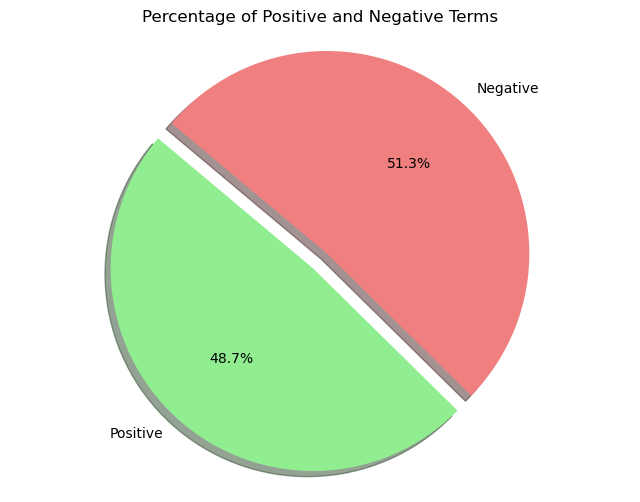

In [89]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Define the tuple of word-frequency pairs
word_freq =lemmatized_word_freq

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze the sentiment of each word and classify as positive or negative
positive_words = []
negative_words = []
for word, _ in word_freq:
    sentiment_scores = sia.polarity_scores(word)
    if sentiment_scores['compound'] >= 0.05:
        positive_words.append(word)
    elif sentiment_scores['compound'] <= -0.05:
        negative_words.append(word)

# Calculate percentages
total_count = sum(freq for _, freq in word_freq)
positive_percentage = (len(positive_words) / total_count) * 100
negative_percentage = (len(negative_words) / total_count) * 100

# Print positive and negative words
print("Positive Words:", positive_words)
print("Negative Words:", negative_words)

# Plotting pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode positive slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title of the pie chart
plt.title('Percentage of Positive and Negative Terms')

# Display the pie chart
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mingshi/nltk_data...


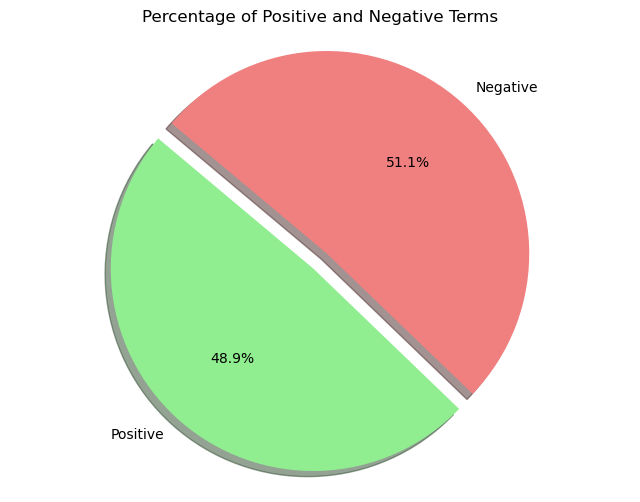

In [88]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Define the tuple of word-frequency pairs
word_freq =lemmatized_word_freq

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze the sentiment of each word and calculate positive and negative scores
positive_score = 0
negative_score = 0
for word, _ in word_freq:
    sentiment_scores = sia.polarity_scores(word)
    positive_score += sentiment_scores['pos']
    negative_score += sentiment_scores['neg']

# Calculate percentages
total_count = sum(freq for _, freq in word_freq)
positive_percentage = (positive_score / total_count) * 100
negative_percentage = (negative_score / total_count) * 100

# Plotting pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode positive slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title of the pie chart
plt.title('Percentage of Positive and Negative Terms')

# Display the pie chart
plt.show()
